Saving dataset.csv to dataset (2).csv
Lasso: Mean R²: -0.561, Std: 1.112
    Mean MSE: 44743269.930, Std: 75255221.578
Linear Regression: Mean R²: -0.885, Std: 1.310
    Mean MSE: 48655477.851, Std: 77198976.172
Random Forest: Mean R²: -0.260, Std: 0.646
    Mean MSE: 40008557.933, Std: 73176004.373
Decision Tree: Mean R²: -2.153, Std: 3.123
    Mean MSE: 53422086.091, Std: 71680598.245
Polynomial Regression: Mean R²: -79.074, Std: 65.687
    Mean MSE: 477194813.692, Std: 199592424.513
XGBoost: Mean R²: -0.964, Std: 1.298
    Mean MSE: 66068083.996, Std: 117718690.177
AdaBoost: Mean R²: -0.614, Std: 1.126
    Mean MSE: 47629550.527, Std: 75044185.368
SVR: Mean R²: -0.211, Std: 0.121
    Mean MSE: 55425660.722, Std: 124265258.122
KNN: Mean R²: 0.011, Std: 0.414
    Mean MSE: 42558177.256, Std: 99124467.847
Gradient Boosting: Mean R²: -0.631, Std: 1.137
    Mean MSE: 48100848.932, Std: 76459825.768


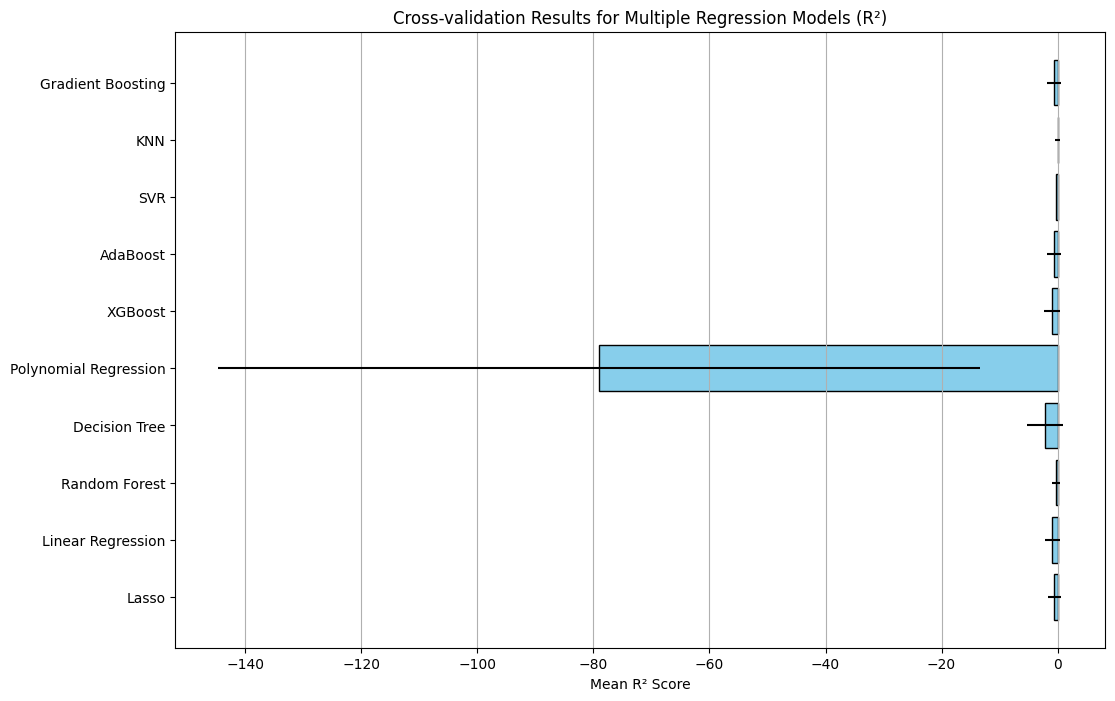

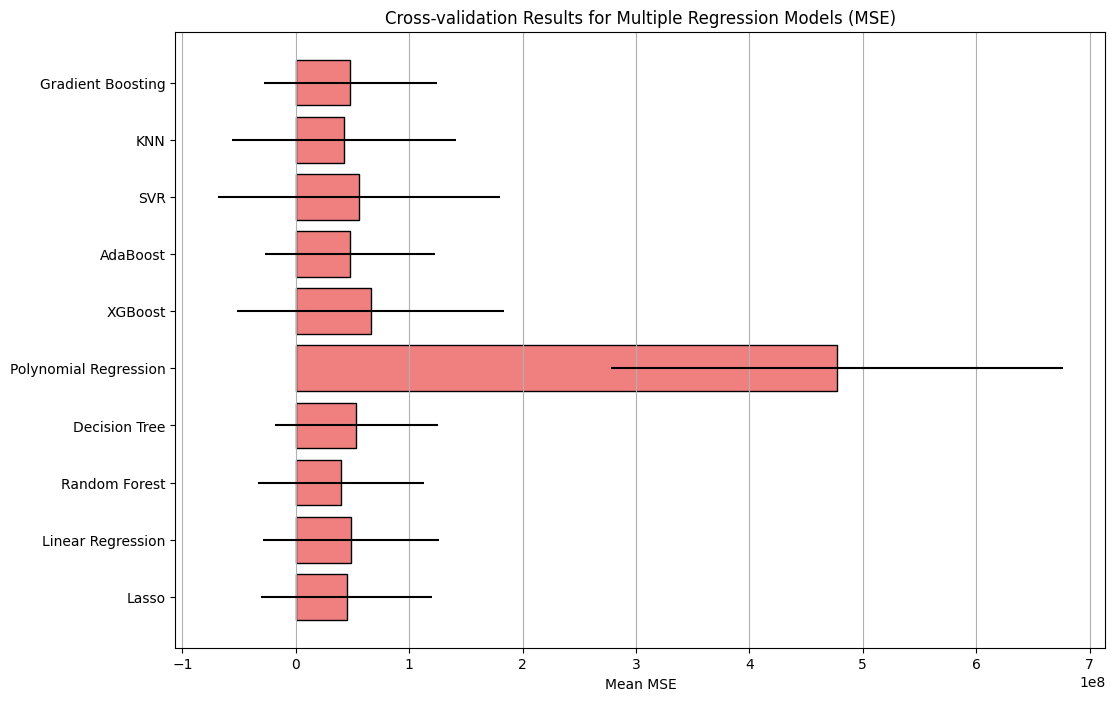

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline  # Importing Pipeline

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Loading the dataset manually
from google.colab import files
uploaded = files.upload()

dataset = pd.read_csv('dataset.csv')

# Step 1: Preprocessing
# Converting all columns to numeric where possible
dataset = dataset.apply(pd.to_numeric, errors='coerce')

# Encode categorical data ('District')
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['District'] = label_encoder.fit_transform(dataset['District'])

# Filling missing values with the mode (or use any other imputation strategy)
dataset.fillna(dataset.mode().iloc[0], inplace=True)

# Creating a target variable ('Total Cases') by summing relevant columns (columns 37-49 represent months)
dataset['Total Cases'] = dataset.iloc[:, 37:49].sum(axis=1)

# Dropping unused columns (e.g., months used for summation and 'Year')
dataset = dataset.drop(dataset.columns[37:49], axis=1)
dataset = dataset.drop(columns=['Year'])

# Step 2: Splitting Data
# Define features (X) and target (Y)
X = dataset.iloc[:, :-1].values  # All columns except 'Total Cases'
Y = dataset.iloc[:, -1].values  # 'Total Cases'

# Split into training and testing sets (80-20))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

# Step 3: Define Models
models = [
    ('Lasso', Lasso(alpha=0.1)),  # Lasso Regression
    ('Linear Regression', LinearRegression()),  # Linear Regression
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=0)),  # Random Forest
    ('Decision Tree', DecisionTreeRegressor(random_state=0)),  # Decision Tree
    ('Polynomial Regression', Pipeline([('poly', PolynomialFeatures(degree=2)),
                                       ('linear', LinearRegression())])),  # Polynomial Regression
    ('XGBoost', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=0)),  # XGBoost
    ('AdaBoost', AdaBoostRegressor(n_estimators=100, random_state=0)),  # AdaBoost
    ('SVR', SVR(kernel='rbf')),  # Support Vector Regression
    ('KNN', KNeighborsRegressor(n_neighbors=5)),  # K-Nearest Neighbors
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=0))  # Gradient Boosting
]

# Step 4: Cross-validation
results = {}
for name, model in models:
    # Use KFold cross-validation to evaluate models
    kfold = KFold(n_splits=10, random_state=0, shuffle=True)  # 10-fold cross-validation

    # Compute R² and MSE for each fold
    r2_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='r2')  # R² score
    mse_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')  # MSE score (negated)

    # Store results (mean R² and mean MSE)
    results[name] = {
        'R² Mean': r2_results.mean(),
        'R² Std': r2_results.std(),
        'MSE Mean': -mse_results.mean(),  # Convert negative MSE to positive
        'MSE Std': mse_results.std()
    }
    print(f'{name}: Mean R²: {r2_results.mean():.3f}, Std: {r2_results.std():.3f}')
    print(f'    Mean MSE: {(-mse_results.mean()):.3f}, Std: {mse_results.std():.3f}')

# Step 5: Visualization of results
model_names = list(results.keys())
mean_r2_scores = [results[name]['R² Mean'] for name in model_names]
std_r2_scores = [results[name]['R² Std'] for name in model_names]
mean_mse_scores = [results[name]['MSE Mean'] for name in model_names]
std_mse_scores = [results[name]['MSE Std'] for name in model_names]

# Plotting R² scores
plt.figure(figsize=(12, 8))
plt.barh(model_names, mean_r2_scores, xerr=std_r2_scores, color='skyblue', edgecolor='black')
plt.xlabel('Mean R² Score')
plt.title('Cross-validation Results for Multiple Regression Models (R²)')
plt.grid(True, axis='x')
plt.show()

# Plotting MSE scores
plt.figure(figsize=(12, 8))
plt.barh(model_names, mean_mse_scores, xerr=std_mse_scores, color='lightcoral', edgecolor='black')
plt.xlabel('Mean MSE')
plt.title('Cross-validation Results for Multiple Regression Models (MSE)')
plt.grid(True, axis='x')
plt.show()
